In [1]:
from wgangp.db_utils import *
from acf_utils import *
from utility import *

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorf

In [2]:
run = 8
number = 5999

In [3]:
path = f'/scratch/scarpolini/lagrangian/wgangp/runs/{run}/{number}_gen.h5'
gen = load_model(path)
trajs = gen.predict(np.random.normal(0, 1, size=(50000, 100)))
np.save(f'wgangp/runs/{run}/gen_trajs_{number}', trajs)

W0531 16:18:26.157219 47731450723840 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0531 16:18:26.158927 47731450723840 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0531 16:18:26.189985 47731450723840 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (fr

In [4]:
path = f'/scratch/scarpolini/lagrangian/wgangp/runs/{run}/gen_trajs_{number}.npy'
gen = np.load(path)

M = gen.max()
m = gen.min()
print('massimo, minimo: ',M,m)

#db = np.load('/scratch/scarpolini/databases/velocities.npy')[:,:,0]
#M = db.max() 
M = 10.273698864467972
#m = db.min()
m = -9.970374739869616
semidisp = (M-m)/2.
media = (M+m)/2.
gen = gen*semidisp + media
print('veri',M,m)
M = gen.max()
m = gen.min()
print('generati',M,m)

massimo, minimo:  0.83121437 -0.83545065
veri 10.273698864467972 -9.970374739869616
generati 8.565245 -8.3048


# PDF V_x e A_x

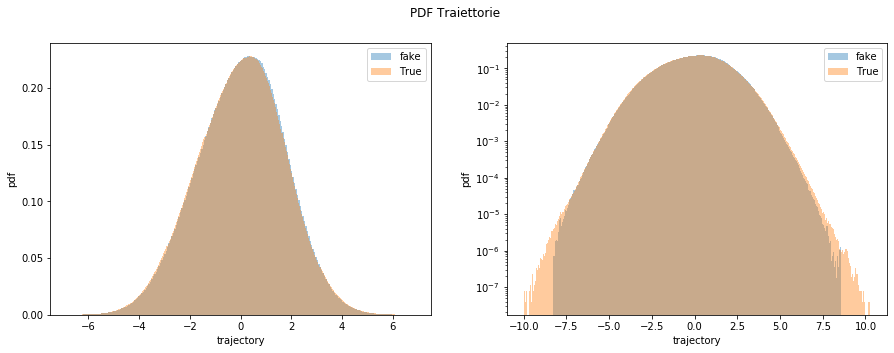

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('PDF Traiettorie')
hist, bin_edges = load_pdf('data/pdf_vx')
ax1.hist(gen.flatten(), bins=300, label='fake', alpha=0.4, density=True)
ax1.hist(bin_edges[:-1], bin_edges, weights=hist, alpha=0.4, label='True')
ax1.set_xlabel('trajectory')
ax1.set_ylabel('pdf')
ax1.set_xlim([-7.5,7.5])
ax1.legend()
ax2.hist(gen.flatten(), bins=300, label='fake', alpha=0.4, density=True)
ax2.hist(bin_edges[:-1], bin_edges, weights=hist, alpha=0.4, label='True')
ax2.set_xlabel('trajectory')
ax2.set_ylabel('pdf')
ax2.legend()
ax2.set_yscale('log')

fig.savefig(f'plots/gan_test_d0_{run}_{number}.png', fmt='png', dpi=100)
plt.show()

In [6]:
gm = np.gradient(gen,axis=1)

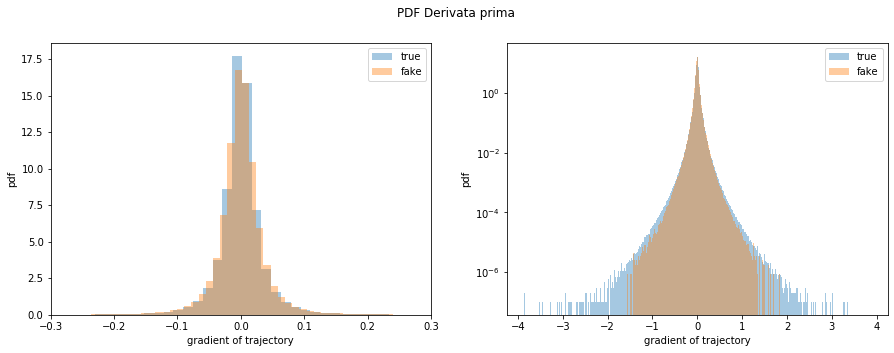

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('PDF Derivata prima')
hist, bin_edges = load_pdf('data/pdf_ax')

ax1.hist(bin_edges[:-1], bin_edges, weights=hist, alpha=0.4, label='true')
ax1.hist(gm.flatten(), bins=300, label='fake', alpha=0.4, density=True)
ax1.legend()
ax1.set_xlabel('gradient of trajectory')
ax1.set_ylabel('pdf')
ax1.set_xlim([-0.3,0.3])

ax2.hist(bin_edges[:-1], bin_edges, weights=hist, alpha=0.4, label='true')
ax2.hist(gm.flatten(), bins=300, label='fake', alpha=0.4, density=True)
ax2.legend()
ax2.set_xlabel('gradient of trajectory')
ax2.set_ylabel('pdf')
ax2.set_yscale('log')

fig.savefig(f'plots/gan_test_d1_{run}_{number}.png', fmt='png', dpi=100)
plt.show()

# ACF_x

In [ ]:
mean = np.load('../databases/velocities_acf_mean_and_std.npy')[0,:,0]
std = np.load('../databases/velocities_acf_mean_and_std.npy')[1,:,0]
plt.figure(figsize=(8,6))
l, caps, c = plt.errorbar(np.arange(2000), mean, std, lw=0, marker='^', errorevery=40,
                          ms=2, elinewidth=1, uplims=True, lolims=True, capsize=2, label='Real')
for cap in caps:
    cap.set_marker("_")

try: acfs = np.load(f'data/acf_x_gen_{run}_{number}.npy')
except:
    acfs = acf_gen_x(gen)
    np.save(f'data/acf_x_gen_{run}_{number}',acfs)
    
mean = acfs.mean(axis=0)
std = acfs.std(axis=0)
l, caps, c = plt.errorbar(np.arange(2000), mean, std, lw=0, marker='^', errorevery=40,
                          ms=2, elinewidth=1, uplims=True, lolims=True, capsize=2, label='Fake')
for cap in caps:
    cap.set_marker("_")

plt.title('funzione autocorrelazione particelle lagrangiane x')
plt.xlim([0,2000])
plt.xlabel('tau')
plt.legend()
plt.ylabel('autocorrelazione')
plt.savefig(f'plots/gan_test_acfx_{run}_{number}.png', fmt='png', dpi=100)
plt.show()

# Exit time

# Plot Traiettorie Generate e Reali

In [ ]:
db = np.load('../databases/velocities.npy')[:,:,0]

In [ ]:
idx1 = np.random.randint(0, db.shape[0], 2)
idx2 = np.random.randint(0, gen.shape[0], 2)
trajs = db[idx1]
gen_trajs = gen[idx2]
plt.figure(figsize=(11, 2*len(trajs)+2*len(gen_trajs)))
plt.title('esempi di traiettorie vere e generate')

for i, traj in enumerate(trajs):
    plt.subplot(len(trajs)+len(gen_trajs), 1, i+1)
    plt.plot(traj, color='red', label='real')
    plt.legend()

for i, traj in enumerate(gen_trajs):
    plt.subplot(len(trajs)+len(gen_trajs), 1, i+1+len(trajs))
    plt.plot(traj, label='generated')
    plt.legend()

plt.tight_layout()
plt.savefig(f'plots/gan_test_trajs_{run}_{number}.png', fmt='png', dpi=100)
plt.show()